In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
from prepare_data import *
from matplotlib.ticker import FuncFormatter
import umap
from top2vec import Top2Vec
import matplotlib.cm as cm
from PIL import Image

# Define file paths

In [12]:
datapath = '/Users/jm7581/Documents/projects/active/AITA/data/'
resultspath = '/Users/jm7581/Documents/projects/active/AITA/results/adroit/'
graphpath = '/Users/jm7581/Documents/projects/active/AITA/graphs/'

# FIG. 1 - Subreddit Info

### Get combined df

In [19]:
years = range(2017, 2023)

# Empty list to hold dataframes
dfs = []

# Loop through each year and read the corresponding Parquet file
for year in years:
    file_path = f'{datapath}AITA_comments_intermediate_{year}.parquet'
    df = pd.read_parquet(file_path, columns = ['author','created_utc', 'link_id', 'YTA', 'NTA', 'ESH', 'NAH', 'INFO', 'score', 'judgement_sum'])
    dfs.append(df)

# Concatenate all dataframes vertically (stack them)
combined_coms = pd.concat(dfs, ignore_index=True)
combined_coms['year'] = combined_coms['created_utc'].dt.year
combined_coms['month'] = combined_coms['created_utc'].dt.month
combined_coms = combined_coms[combined_coms['year'] != 2023]

### Get number of posts over time (A)

/var/folders/5w/62q1kz1164n7vbnq548l_6n80000gq/T/ipykernel_82166/2816887393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['year_month'] = posts['year'].astype(str) + '-' + posts['month'].astype(str).str.zfill(2)
/var/folders/5w/62q1kz1164n7vbnq548l_6n80000gq/T/ipykernel_82166/2816887393.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['year_month'] = users['year'].astype(str) + '-' + users['month'].astype(str).str.zfill(2)


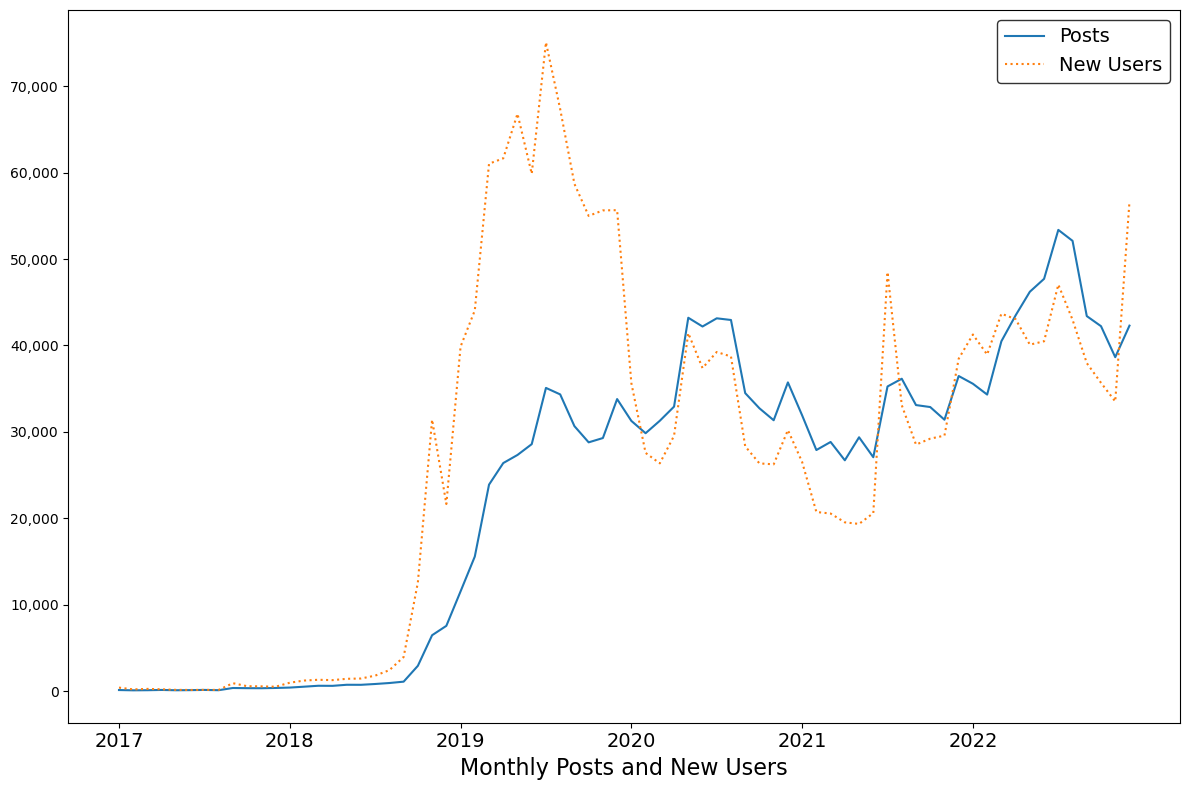

In [20]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# Remove duplicates by 'link_id' for posts
posts = combined_coms.drop_duplicates('link_id')
posts['year_month'] = posts['year'].astype(str) + '-' + posts['month'].astype(str).str.zfill(2)
posts_counts = posts.groupby('year_month')['link_id'].nunique()

# Remove duplicates by 'author' for users
users = combined_coms.drop_duplicates('author')
users['year_month'] = users['year'].astype(str) + '-' + users['month'].astype(str).str.zfill(2)
users_counts = users.groupby('year_month')['year_month'].count()

# Create the figure
plt.figure(figsize=(12, 8))

# Plot number of posts (dark blue solid line)
plt.plot(posts_counts.index, posts_counts.values, linestyle='-', label='Posts')

# Plot number of users (orange dotted line)
plt.plot(users_counts.index, users_counts.values, linestyle=':', label='New Users')

# X ticks (years only)
years = [year.split('-')[0] for year in posts_counts.index]
year_ticks = [i for i, year in enumerate(years) if year != years[i - 1]]  # Start of each year
year_labels = [year for i, year in enumerate(years) if year != years[i - 1]]
plt.xticks(ticks=year_ticks, labels=year_labels, rotation=0, ha='center', size=14)

# Format the y-axis to avoid scientific notation
def format_y_ticks(x, pos):
    return f'{int(x):,}'  # Format with commas

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

# Labeling the plot
plt.xlabel('Monthly Posts and New Users', fontsize=16)

# Add the legend
plt.legend(fontsize=14, edgecolor='black', fancybox=True, frameon=True, loc='upper right')

# Save as high-resolution TIFF
plt.tight_layout()
plt.savefig(f'{graphpath}num_posts_users_new.tif', bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


### Get proportion of posts with different judgements (B)

In [21]:
years = range(2017, 2023)

# Empty list to hold dataframes
dfs = []

# Loop through each year and read the corresponding Parquet file
for year in years:
    file_path = f'{datapath}AITA_comments_intermediate_{year}.parquet'
    df = pd.read_parquet(file_path, columns = ['created_utc', 'link_id', 'parent_id', 'YTA', 'NTA', 'ESH', 'NAH', 'INFO', 'score', 'judgement_sum'])
    dfs.append(df)

# Concatenate all dataframes vertically (stack them)
combined_coms = pd.concat(dfs, ignore_index=True)

combined_coms['parent_id'] = combined_coms['parent_id'].apply(lambda x: x[3:] if x.startswith('t') else x)
combined_coms['link_id'] = combined_coms['link_id'].apply(lambda x: x[3:] if x.startswith('t') else x)

combined_coms = combined_coms[combined_coms['link_id'] == combined_coms['parent_id']]


combined_coms['year'] = combined_coms['created_utc'].dt.year
combined_coms['month'] = combined_coms['created_utc'].dt.month
combined_coms['num_comments'] = combined_coms.groupby('link_id')['link_id'].transform('count')
combined_coms = combined_coms[combined_coms['num_comments'] > 14]

combined_coms = get_weighted_judgement_scores(combined_coms)
combined_coms = get_final_judgements(combined_coms)

/Users/jm7581/Documents/Projects/Active/AITA/code/python/prepare_data.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coms['max_score'] = coms[(coms['YTA'] != 0) | (coms['NTA'] != 0) | (coms['ESH'] != 0) | (coms['NAH'] != 0) | (coms['INFO'] != 0)].groupby('link_id')['score'].transform('max')
/Users/jm7581/Documents/Projects/Active/AITA/code/python/prepare_data.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coms['highest_com_judgement'] = coms.apply(lambda row: get_judgement(row) if row['score']

0.9686734921698363


In [22]:
combined_coms['year'].unique()

array([2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int32)

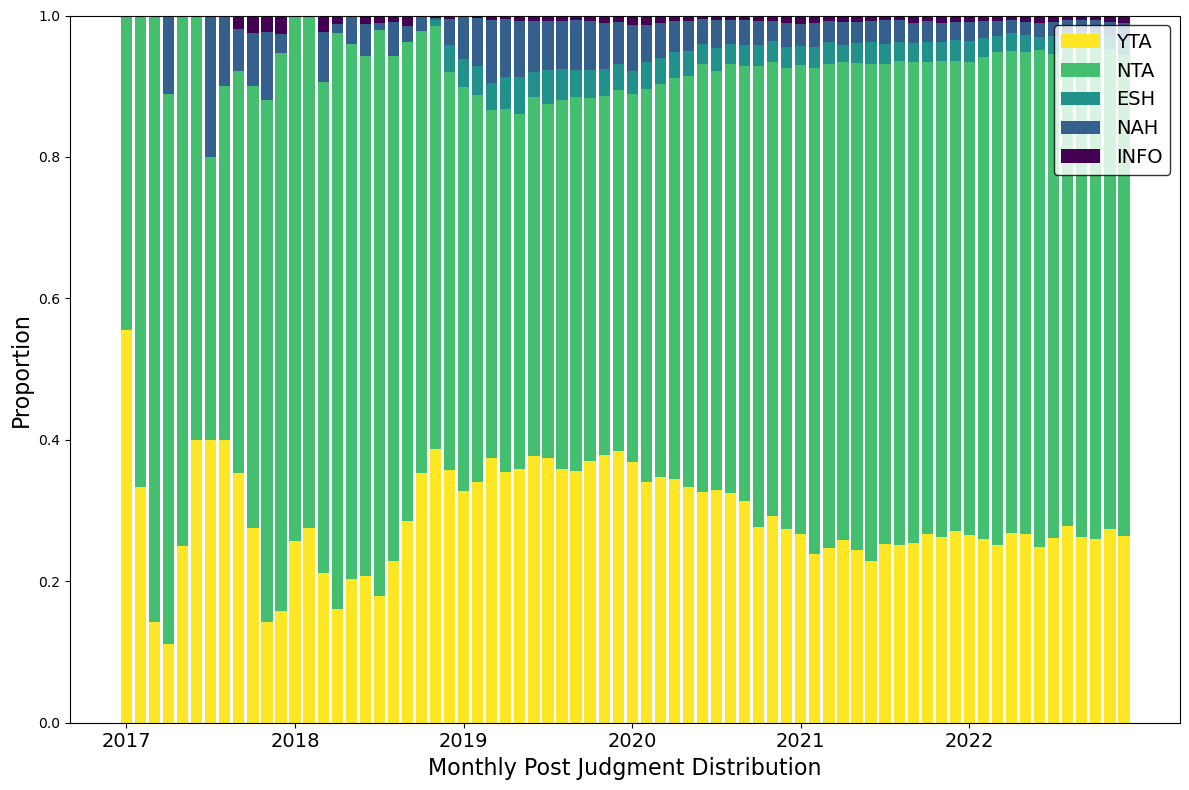

In [25]:
post_outcomes = combined_coms.drop_duplicates('link_id')
post_outcomes = post_outcomes[post_outcomes['year'] != 2023]

YTA_prop = (post_outcomes.groupby(['year', 'month'])['majority_judgement'].apply(lambda x: (x == 'YTA').sum()) / post_outcomes.groupby(['year', 'month']).size()).reset_index()
NTA_prop = (post_outcomes.groupby(['year', 'month'])['majority_judgement'].apply(lambda x: (x == 'NTA').sum()) / post_outcomes.groupby(['year', 'month']).size()).reset_index()
ESH_prop = (post_outcomes.groupby(['year', 'month'])['majority_judgement'].apply(lambda x: (x == 'ESH').sum()) / post_outcomes.groupby(['year', 'month']).size()).reset_index()
NAH_prop = (post_outcomes.groupby(['year', 'month'])['majority_judgement'].apply(lambda x: (x == 'NAH').sum()) / post_outcomes.groupby(['year', 'month']).size()).reset_index()
INFO_prop = (post_outcomes.groupby(['year', 'month'])['majority_judgement'].apply(lambda x: (x == 'INFO').sum()) / post_outcomes.groupby(['year', 'month']).size()).reset_index()

# Combine all proportions into one DataFrame
props = pd.DataFrame([YTA_prop[0], NTA_prop[0], ESH_prop[0], NAH_prop[0], INFO_prop[0]]).T
props.columns = ['YTA', 'NTA', 'ESH', 'NAH', 'INFO']

# Color palette using viridis colormap
colors = cm.viridis([1.0, 0.7, 0.5, 0.3, 0])

# Set up the figure size
plt.figure(figsize=(12, 8))

# Get the positions for each bar (monthly data)
bar_width = 0.8
months = props.index
year_ticks = np.arange(len(months))  # x positions for each group (month)

# Stack the bars manually (each one on top of the previous)
bottoms = np.zeros(len(months))  # Start from the bottom of the chart

# Plot each category (YTA, NTA, ESH, NAH, INFO) as stacked bars
for i, category in enumerate(props.columns):
    plt.bar(year_ticks, props[category], bottom=bottoms, label=category, color=colors[i])
    bottoms += props[category]  # Update the bottom to stack the next bar

# Set the x-ticks (month names or years)

years = YTA_prop['year'].unique()
year_ticks = [YTA_prop[(YTA_prop['year'] == year) & (YTA_prop['month'] == 1)].index[0] for year in years]
plt.xticks(ticks=year_ticks, labels=years, rotation=0, size = 14)

# Labeling the plot
plt.xlabel('Monthly Post Judgment Distribution', fontsize=16)
plt.ylabel('Proportion', fontsize=16)

# Add a legend
plt.legend(fontsize=14, edgecolor='black', fancybox=True, frameon=True, loc='upper right')

# Adjust layout to avoid clipping
plt.tight_layout()

# Save the plot as a TIFF file with high resolution
plt.savefig(f'{graphpath}proportion_new.tif', bbox_inches="tight", dpi=300)

# Show the plot
plt.show()

### Combine into one plot

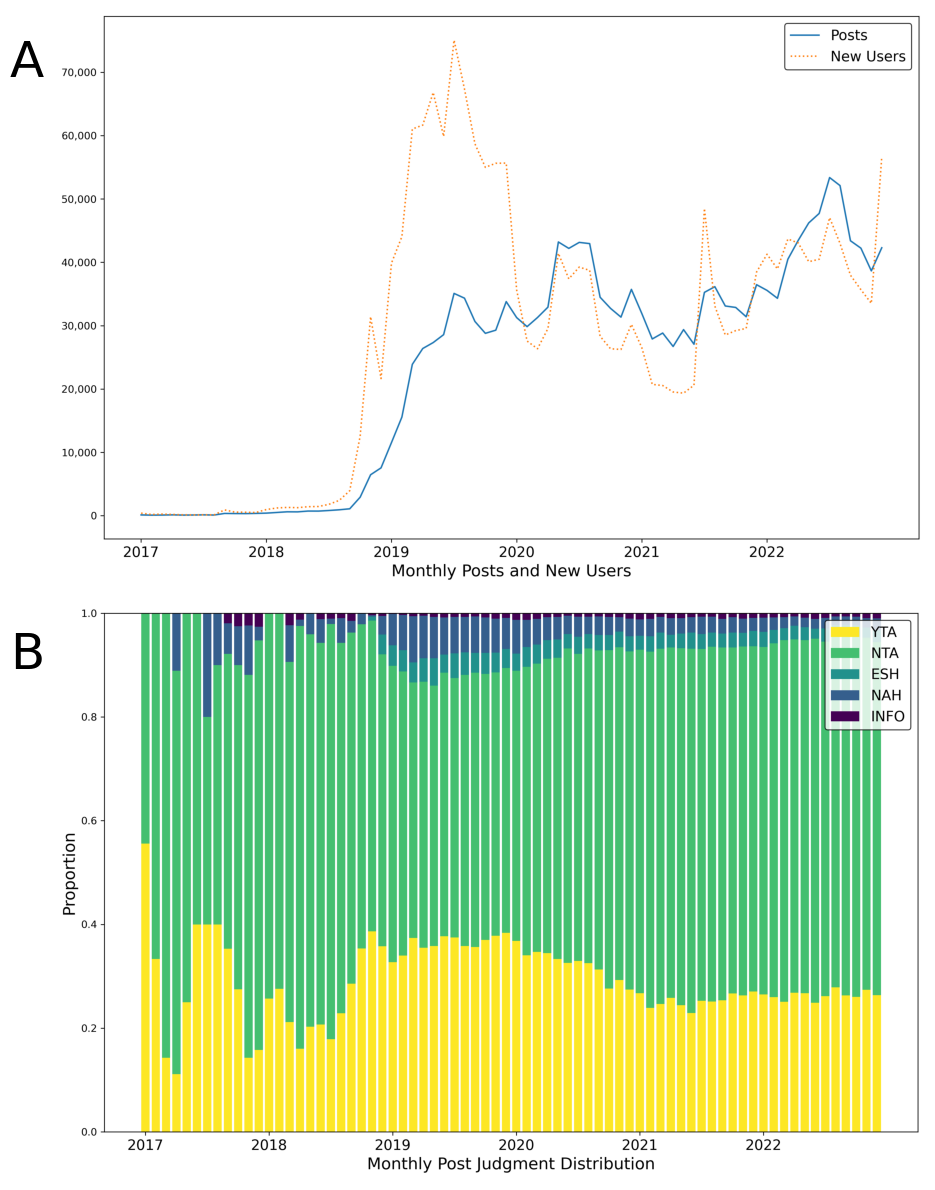

In [28]:
from matplotlib import image as mpimg

# List of your .tif files
tif_files = [
    'num_posts_users_new.tif',
    'proportion.tif'
]

# Create subplots (2 rows, 1 column for vertically stacked plots)
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Loop over each subplot and load the corresponding image file
for i, ax in enumerate(axes):
    img = mpimg.imread(f'{graphpath}{tif_files[i]}')  # Read the .tif file as an image
    ax.imshow(img)  # Show the image in the subplot
    ax.axis('off')  # Turn off the axis for clarity (optional)
    
    # Add the panel label (A, B)
    ax.text(-0.05, 0.95, f'{chr(65 + i)}', transform=ax.transAxes, 
            fontsize=36, va='top', ha='left', color='black')

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(f'{graphpath}fig1_raw.tif', bbox_inches="tight", dpi = 300)

# Show the plot
plt.show()

# FIG. 2 - Main Result

In [38]:
#get effect sizes
df = pd.read_stata(f'{resultspath}margins_main_1.dta')
for i in range(len(df)):
    result = (np.exp(df['_margin'][i]) - 1) * 100
    pvalue = df['_pvalue'][i]
    print(result)
    print(pvalue)
    

-9.09421443939209
0.0012724691
21.39841318130493
0.0
30.36801815032959
0.0
12.581169605255127
0.0
-21.819746494293213
2.1344622e-32


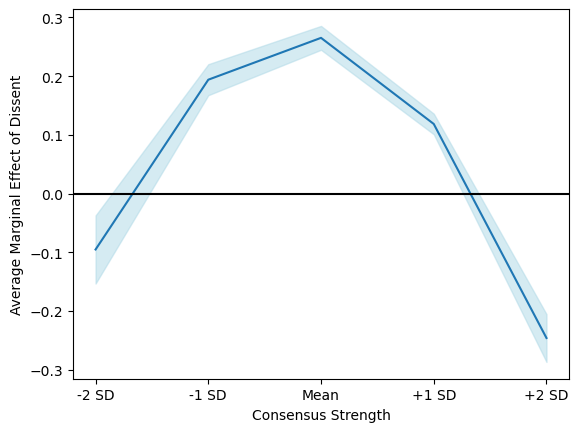

In [13]:
df = pd.read_stata(f'{resultspath}margins_main_1.dta')
at_options = df['_atopt'][0]
at_options = re.findall(r"[-+]?\d*\.\d+|\d+", at_options)
at_options = [float(num) for num in at_options]
df['at_options'] = at_options
df = df[['at_options', '_margin', '_pvalue', '_ci_lb', '_ci_ub']]
df = df.rename(columns = {'_margin': 'margin', '_pvalue': 'pvalue', '_ci_lb': 'lower_bound', '_ci_ub': 'upper_bound'})
index_labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
df.index = index_labels

plt.plot(df.index, df['margin'])
plt.fill_between(df.index, df['lower_bound'], df['upper_bound'], 
                 color='lightblue', alpha=0.5, label='Confidence Interval')
plt.axhline(0, color = 'black')
plt.ylabel('Average Marginal Effect of Dissent')
plt.xlabel('Consensus Strength')
plt.savefig(f'{graphpath}fig2_raw.tif', bbox_inches="tight", dpi = 300)

# Cubic

In [11]:
#get effect sizes
df = pd.read_stata(f'{resultspath}margins_cubic.dta')
for i in range(len(df)):
    result = (np.exp(df['_margin'][i]) - 1) * 100
    pvalue = df['_pvalue'][i]
    print(result)
    print(pvalue)
    

-14.19714093208313
3.2149416e-07
33.96955728530884
0.0
28.061962127685547
0.0
4.4936418533325195
2.4015168e-05
1.4755010604858398
0.46811116


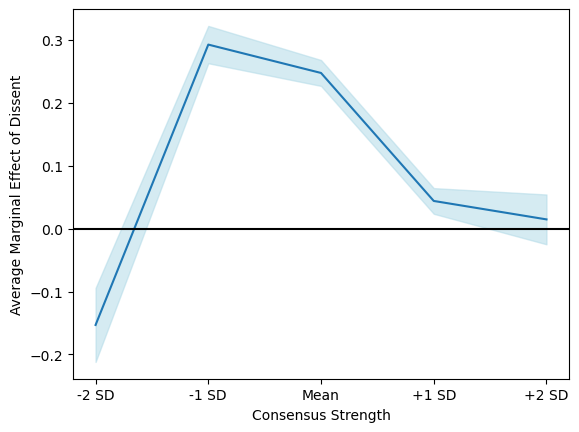

In [12]:
df = pd.read_stata(f'{resultspath}margins_cubic.dta')
at_options = df['_atopt'][0]
at_options = re.findall(r"[-+]?\d*\.\d+|\d+", at_options)
at_options = [float(num) for num in at_options]
df['at_options'] = at_options
df = df[['at_options', '_margin', '_pvalue', '_ci_lb', '_ci_ub']]
df = df.rename(columns = {'_margin': 'margin', '_pvalue': 'pvalue', '_ci_lb': 'lower_bound', '_ci_ub': 'upper_bound'})
index_labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
df.index = index_labels

plt.plot(df.index, df['margin'])
plt.fill_between(df.index, df['lower_bound'], df['upper_bound'], 
                 color='lightblue', alpha=0.5, label='Confidence Interval')
plt.axhline(0, color = 'black')
plt.ylabel('Average Marginal Effect of Dissent')
plt.xlabel('Consensus Strength')
plt.savefig(f'{graphpath}fig2_raw_cubic.tif', bbox_inches="tight", dpi = 300)

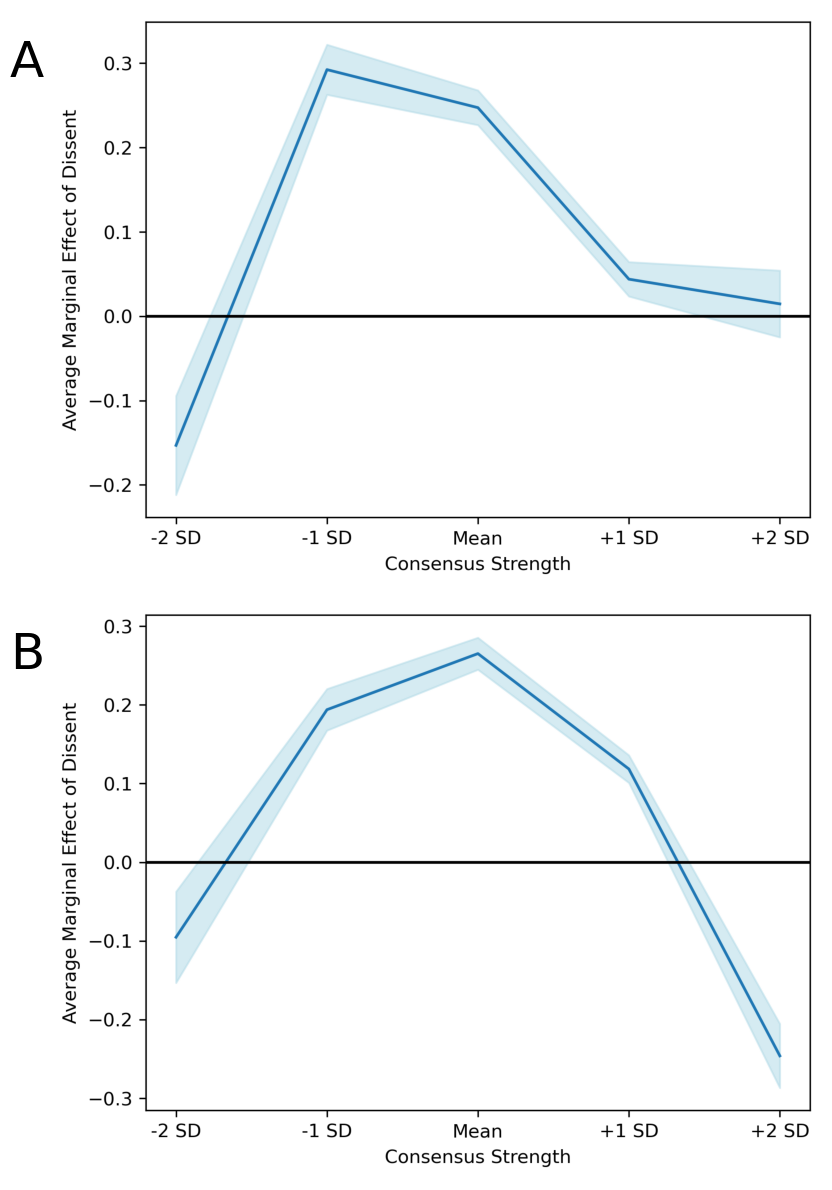

In [37]:
from matplotlib import image as mpimg

# List of your .tif files
tif_files = [
    'fig2_raw_cubic.tif',
    'fig2_raw.tif'
]

# Create subplots (2 rows, 1 column for vertically stacked plots)
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Loop over each subplot and load the corresponding image file
for i, ax in enumerate(axes):
    img = mpimg.imread(f'{graphpath}{tif_files[i]}')  # Read the .tif file as an image
    ax.imshow(img)  # Show the image in the subplot
    ax.axis('off')  # Turn off the axis for clarity (optional)
    
    # Add the panel label (A, B)
    ax.text(-0.05, 0.95, f'{chr(65 + i)}', transform=ax.transAxes, 
            fontsize=36, va='top', ha='left', color='black')

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(f'{graphpath}fig2_raw.tif', bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


# FIG 3. - Topic UMAP + Topic Heterogeneity

In [4]:
#get effect sizes
for j in range(10):
    df = pd.read_stata(f'{resultspath}margins_topic_{j}.dta')

    for i in range(len(df)):
        result = (np.exp(df['_margin'][i]) - 1) * 100
        pvalue = df['_pvalue'][i]
        print(result)
        print(pvalue)
    print('-------------')
    

-1.824253797531128
0.62521017
23.62900972366333
0.0
28.271102905273438
0.0
9.655261039733887
1.1120244e-11
-22.763532400131226
2.3257429e-11
-------------
-14.57911729812622
0.00011974973
18.73629093170166
5.241035e-22
30.334579944610596
0.0
12.97769546508789
3.4994514e-12
-22.66385555267334
9.668121e-07
-------------
-2.2607266902923584
0.54887885
19.627761840820312
7.216608e-30
23.818111419677734
0.0
8.374130725860596
8.888175e-10
-19.784849882125854
3.193975e-08
-------------
3.135859966278076
0.40902647
18.851900100708008
1.8374572e-27
20.30167579650879
0.0
6.956303119659424
8.887751e-08
-16.476190090179443
9.8361015e-06
-------------
-3.12802791595459
0.4095837
21.814310550689697
5.800704e-34
26.260948181152344
0.0
7.872402667999268
5.6219415e-11
-24.03348684310913
8.174545e-12
-------------
-13.447749614715576
0.0024679755
13.221609592437744
1.2565932e-10
23.92040491104126
1.1066394e-33
13.479888439178467
2.8167622e-14
-13.05241584777832
0.0030154195
-------------
-2.376890182495

In [ ]:
model = Top2Vec.load(f'{datapath}aitamodel')

In [ ]:
# from sklearn.cluster import KMeans
# num_clusters = 10
# kmeans = KMeans(n_clusters=num_clusters)
# clusters = kmeans.fit_predict(umap_embeddings)

# # Get cluster centers
# cluster_centers = kmeans.cluster_centers_

In [ ]:
np.random.seed(3)
embeddings = model.document_vectors
%time umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', verbose=True).fit_transform(embeddings)
x, y = umap_embeddings[:,0], umap_embeddings[:,1]

In [ ]:
#PLOT AT THE AVERAGE COORDINATES

plt.figure(figsize=(10, 7))
np.random.seed(3)
topics = {0:'Health', 1:'Neighbors', 2:'Money', 3:'Events', 4:'Chores', 5:'Dating', 6:'Bigotry', 7:'Social Media', 8:'School', 9:'Work'}

num_points_per_value = 1000

# Get unique values
unique_values = np.unique(model.doc_top_reduced)

# Dictionary to hold averages for each unique value
averages = {}

for value in unique_values:
    # Get indices for the current unique value
    value_indices = np.where(model.doc_top_reduced == value)[0]
    
    # Check if there are enough points
    if len(value_indices) > num_points_per_value:
        # Randomly select 100 indices
        selected_indices = np.random.choice(value_indices, size=num_points_per_value, replace=False)
    else:
        # Use all available points if less than 100
        selected_indices = value_indices
    
    # Compute the averages
    average_x = np.mean(x[selected_indices])
    average_y = np.mean(y[selected_indices])
    
    # Store the results in the dictionary
    averages[value] = {
        'average_x': average_x,
        'average_y': average_y
    }
    

def adjust_labels(averages, min_distance):
    adjusted = {}
    positions = np.array([(avg['average_x'], avg['average_y']) for avg in averages.values()])
    labels = list(averages.keys())

    for i, (value, avg) in enumerate(averages.items()):
        pos = np.array([avg['average_x'], avg['average_y']])
        for j in range(len(positions)):
            if i != j:
                other_pos = positions[j]
                distance = np.linalg.norm(pos - other_pos)
                if distance < min_distance:
                    offset = (min_distance - distance) / 2
                    angle = np.arctan2(other_pos[1] - pos[1], other_pos[0] - pos[0])
                    pos[0] -= offset * np.cos(angle)
                    pos[1] -= offset * np.sin(angle)
        adjusted[value] = {'x': pos[0], 'y': pos[1]}
        positions[i] = pos
    return adjusted

# Adjust labels to avoid overlap
min_distance = 4  # Minimum distance between labels
adjusted_averages = adjust_labels(averages, min_distance)

for value, avg in adjusted_averages.items():
    plt.text(avg['x'], avg['y'], f'{topics[value]}', fontsize=12, ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'))

plt.scatter(x,y,c=model.doc_top_reduced, cmap='viridis', s = 0.7, edgecolor = 'black', linewidth = 0.1)
plt.xlim([-6,6])
plt.ylim([-6,6])
#plt.colorbar()
plt.savefig(f'{graphpath}umap.tif', bbox_inches="tight", dpi = 300)

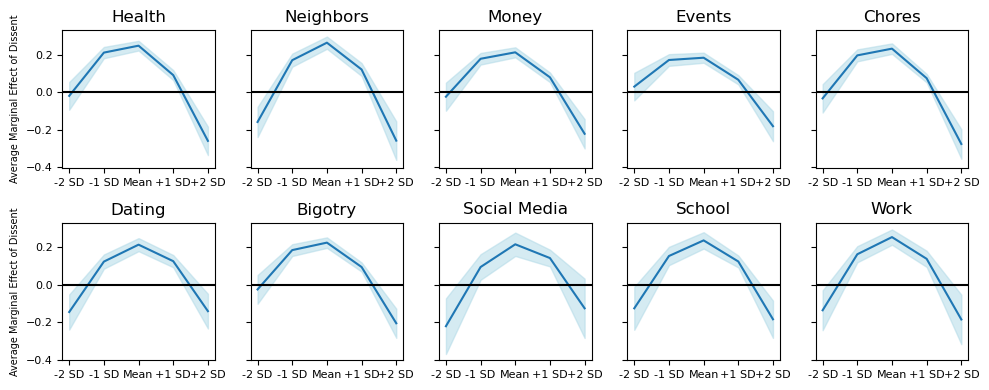

In [7]:
import math

dfs = []
for df_num in range(10):
    df = pd.read_stata(f'{resultspath}margins_topic_{df_num}.dta')
    at_options = df['_atopt'][0]
    at_options = re.findall(r"[-+]?\d*\.\d+|\d+", at_options)
    at_options = [float(num) for num in at_options]
    df['at_options'] = at_options
    df = df[['at_options', '_margin', '_pvalue', '_ci_lb', '_ci_ub']]
    df = df.rename(columns = {'_margin': 'margin', '_pvalue': 'pvalue', '_ci_lb': 'lower_bound', '_ci_ub': 'upper_bound'})
    index_labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
    df.index = index_labels
    dfs.append(df)

titles = ['Health', 'Neighbors', 'Money', 'Events', 'Chores', 'Dating', 'Bigotry', 'Social Media', 'School', 'Work']

# Calculate the number of rows and columns based on the number of subplots
n_plots = len(dfs)
n_cols = 5  # Set the number of columns you want
n_rows = math.ceil(n_plots / n_cols)  # Calculate the number of rows needed

# Create subplots with calculated rows and columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4), sharey=True)

# Flatten the axes array to iterate over easily
axes = axes.flatten()

# Plotting loop
for i, (ax, df) in enumerate(zip(axes, dfs)):
    ax.plot(df.index, df['margin'])
    ax.fill_between(df.index, df['lower_bound'], df['upper_bound'], 
                    color='lightblue', alpha=0.5, label='Confidence Interval')
    ax.axhline(0, color = 'black')
    ax.set_title(titles[i], size = 12)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)
    if i % 5 == 0:  # For the first column only
        ax.set_ylabel('Average Marginal Effect of Dissent', fontsize=7)  # Adjust the label text and size

# Hide unused subplots if any
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{graphpath}heterogeneity.tif', bbox_inches="tight", dpi = 300)
plt.show()


#### Combine into one plot

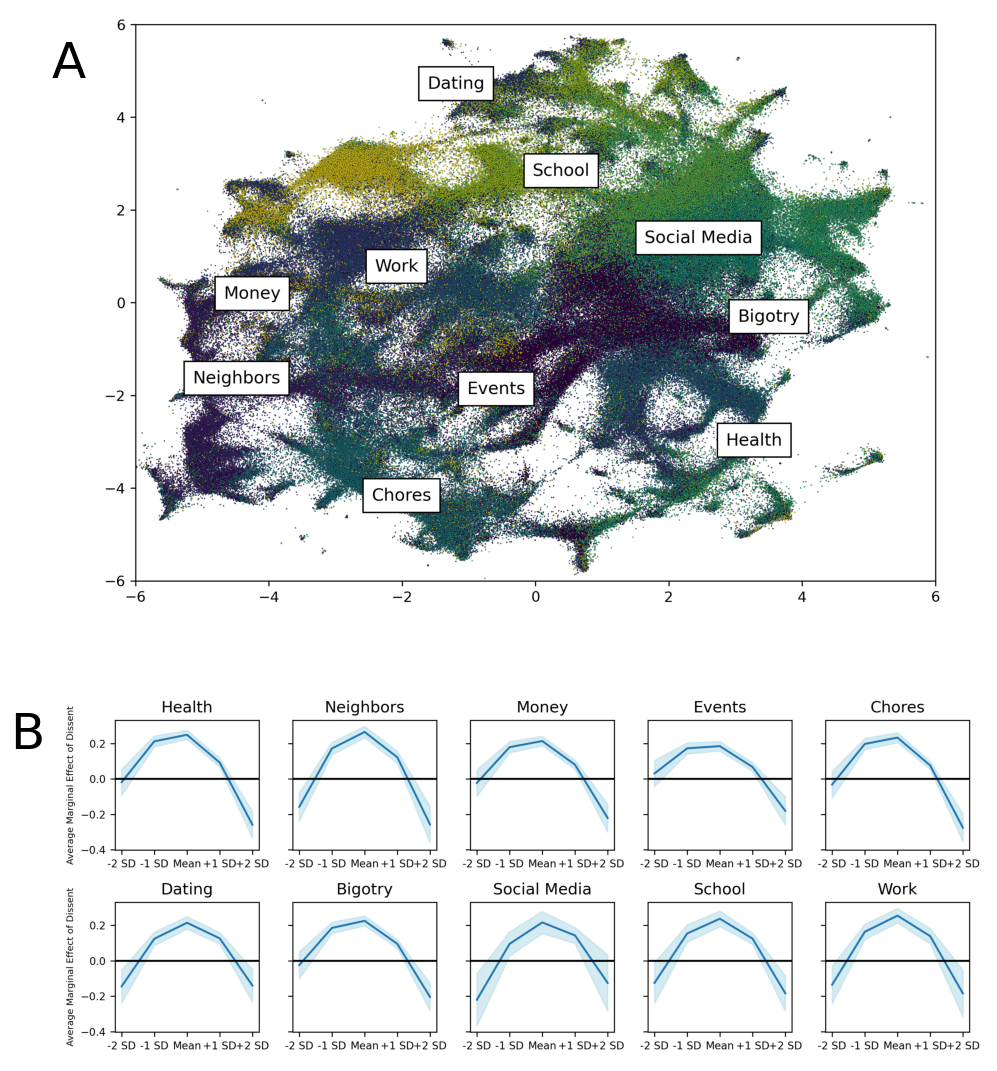

In [14]:
from matplotlib import image as mpimg

# List of your .tif files
tif_files = [
    'umap.tif',
    'heterogeneity.tif'
]

# Create subplots (2 rows, 1 column for vertically stacked plots)
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Loop over each subplot and load the corresponding image file
for i, ax in enumerate(axes):
    img = mpimg.imread(f'{graphpath}{tif_files[i]}')  # Read the .tif file as an image
    ax.imshow(img)  # Show the image in the subplot
    ax.axis('off')  # Turn off the axis for clarity (optional)
    
    # Add the panel label (A, B)
    ax.text(-0.05, 0.95, f'{chr(65 + i)}', transform=ax.transAxes, 
            fontsize=36, va='top', ha='left', color='black')

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(f'{graphpath}fig3_raw.tif', bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


# RE-DO With CUBIC MODEL MARGINS

In [6]:
#get effect sizes
for j in range(10):
    df = pd.read_stata(f'{resultspath}margins_topic_{j}_cubic.dta')

    for i in range(len(df)):
        result = (np.exp(df['_margin'][i]) - 1) * 100
        pvalue = df['_pvalue'][i]
        print(result)
        print(pvalue)
    print('-------------')
    

-2.9904425144195557
0.41660994
33.21033716201782
0.0
23.916494846343994
0.0
6.234109401702881
2.5533513e-05
14.187431335449219
0.008245555
-------------
-19.05859112739563
4.7823494e-07
28.258240222930908
2.0374787e-31
26.78471803665161
0.0
7.393741607666016
3.1245396e-05
7.074189186096191
0.12568259
-------------
-6.662029027938843
0.076156415
28.046774864196777
1.7349566e-36
20.59953212738037
0.0
3.7264108657836914
0.0058687963
8.367681503295898
0.21925859
-------------
0.7605552673339844
0.84214586
25.383329391479492
1.4974893e-28
16.900789737701416
6.3375993e-31
3.8267970085144043
0.008675946
11.68677806854248
0.07483374
-------------
-5.134391784667969
0.17561756
30.5647611618042
0.0
21.517467498779297
0.0
5.225944519042969
0.00015196523
16.641783714294434
0.028002454
-------------
-17.132669687271118
0.00020034675
20.101118087768555
1.6170406e-13
20.260930061340332
4.718653e-25
9.07297134399414
4.1187e-07
17.469775676727295
0.030996172
-------------
-4.48262095451355
0.24230792
2

In [8]:
model = Top2Vec.load(f'{datapath}aitamodel')

In [9]:
np.random.seed(3)
embeddings = model.document_vectors
%time umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', verbose=True).fit_transform(embeddings)
x, y = umap_embeddings[:,0], umap_embeddings[:,1]

UMAP(angular_rp_forest=True, metric='cosine', verbose=True)
Wed Aug 13 17:26:56 2025 Construct fuzzy simplicial set
Wed Aug 13 17:26:57 2025 Finding Nearest Neighbors
Wed Aug 13 17:26:57 2025 Building RP forest with 45 trees
Wed Aug 13 17:27:32 2025 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	 7  /  19
	 8  /  19
	 9  /  19
	 10  /  19
	 11  /  19
	Stopping threshold met -- exiting after 11 iterations
Wed Aug 13 17:27:50 2025 Finished Nearest Neighbor Search
Wed Aug 13 17:27:52 2025 Construct embedding


KeyboardInterrupt: 

NameError: name 'umap_embeddings' is not defined

In [ ]:
#PLOT AT THE AVERAGE COORDINATES

plt.figure(figsize=(10, 7))
np.random.seed(3)
topics = {0:'Health', 1:'Neighbors', 2:'Money', 3:'Events', 4:'Chores', 5:'Dating', 6:'Bigotry', 7:'Social Media', 8:'School', 9:'Work'}

num_points_per_value = 1000

# Get unique values
unique_values = np.unique(model.doc_top_reduced)

# Dictionary to hold averages for each unique value
averages = {}

for value in unique_values:
    # Get indices for the current unique value
    value_indices = np.where(model.doc_top_reduced == value)[0]
    
    # Check if there are enough points
    if len(value_indices) > num_points_per_value:
        # Randomly select 100 indices
        selected_indices = np.random.choice(value_indices, size=num_points_per_value, replace=False)
    else:
        # Use all available points if less than 100
        selected_indices = value_indices
    
    # Compute the averages
    average_x = np.mean(x[selected_indices])
    average_y = np.mean(y[selected_indices])
    
    # Store the results in the dictionary
    averages[value] = {
        'average_x': average_x,
        'average_y': average_y
    }
    

def adjust_labels(averages, min_distance):
    adjusted = {}
    positions = np.array([(avg['average_x'], avg['average_y']) for avg in averages.values()])
    labels = list(averages.keys())

    for i, (value, avg) in enumerate(averages.items()):
        pos = np.array([avg['average_x'], avg['average_y']])
        for j in range(len(positions)):
            if i != j:
                other_pos = positions[j]
                distance = np.linalg.norm(pos - other_pos)
                if distance < min_distance:
                    offset = (min_distance - distance) / 2
                    angle = np.arctan2(other_pos[1] - pos[1], other_pos[0] - pos[0])
                    pos[0] -= offset * np.cos(angle)
                    pos[1] -= offset * np.sin(angle)
        adjusted[value] = {'x': pos[0], 'y': pos[1]}
        positions[i] = pos
    return adjusted

# Adjust labels to avoid overlap
min_distance = 4  # Minimum distance between labels
adjusted_averages = adjust_labels(averages, min_distance)

for value, avg in adjusted_averages.items():
    plt.text(avg['x'], avg['y'], f'{topics[value]}', fontsize=12, ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'))

plt.scatter(x,y,c=model.doc_top_reduced, cmap='viridis', s = 0.7, edgecolor = 'black', linewidth = 0.1)
plt.xlim([-6,6])
plt.ylim([-6,6])
#plt.colorbar()
plt.savefig(f'{graphpath}umap.tif', bbox_inches="tight", dpi = 300)

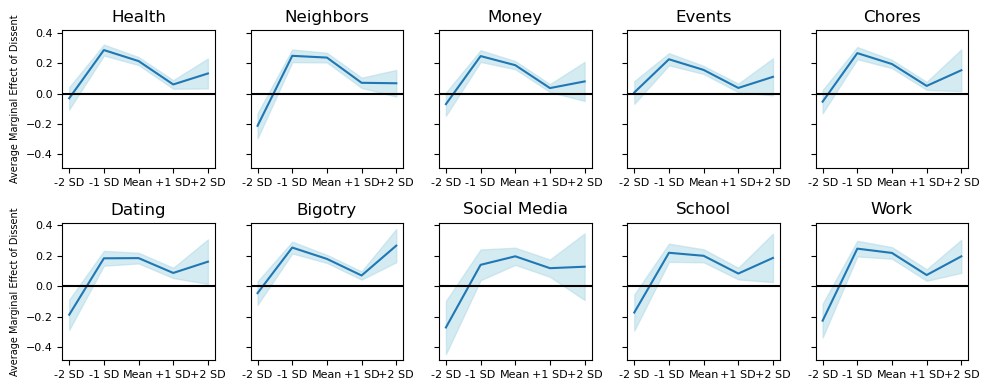

In [7]:
import math

dfs = []
for df_num in range(10):
    df = pd.read_stata(f'{resultspath}margins_topic_{df_num}_cubic.dta')
    at_options = df['_atopt'][0]
    at_options = re.findall(r"[-+]?\d*\.\d+|\d+", at_options)
    at_options = [float(num) for num in at_options]
    df['at_options'] = at_options
    df = df[['at_options', '_margin', '_pvalue', '_ci_lb', '_ci_ub']]
    df = df.rename(columns = {'_margin': 'margin', '_pvalue': 'pvalue', '_ci_lb': 'lower_bound', '_ci_ub': 'upper_bound'})
    index_labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
    df.index = index_labels
    dfs.append(df)

titles = ['Health', 'Neighbors', 'Money', 'Events', 'Chores', 'Dating', 'Bigotry', 'Social Media', 'School', 'Work']

# Calculate the number of rows and columns based on the number of subplots
n_plots = len(dfs)
n_cols = 5  # Set the number of columns you want
n_rows = math.ceil(n_plots / n_cols)  # Calculate the number of rows needed

# Create subplots with calculated rows and columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4), sharey=True)

# Flatten the axes array to iterate over easily
axes = axes.flatten()

# Plotting loop
for i, (ax, df) in enumerate(zip(axes, dfs)):
    ax.plot(df.index, df['margin'])
    ax.fill_between(df.index, df['lower_bound'], df['upper_bound'], 
                    color='lightblue', alpha=0.5, label='Confidence Interval')
    ax.axhline(0, color = 'black')
    ax.set_title(titles[i], size = 12)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)
    if i % 5 == 0:  # For the first column only
        ax.set_ylabel('Average Marginal Effect of Dissent', fontsize=7)  # Adjust the label text and size

# Hide unused subplots if any
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{graphpath}heterogeneity_cubic.tif', bbox_inches="tight", dpi = 300)
plt.show()


# COMBINE

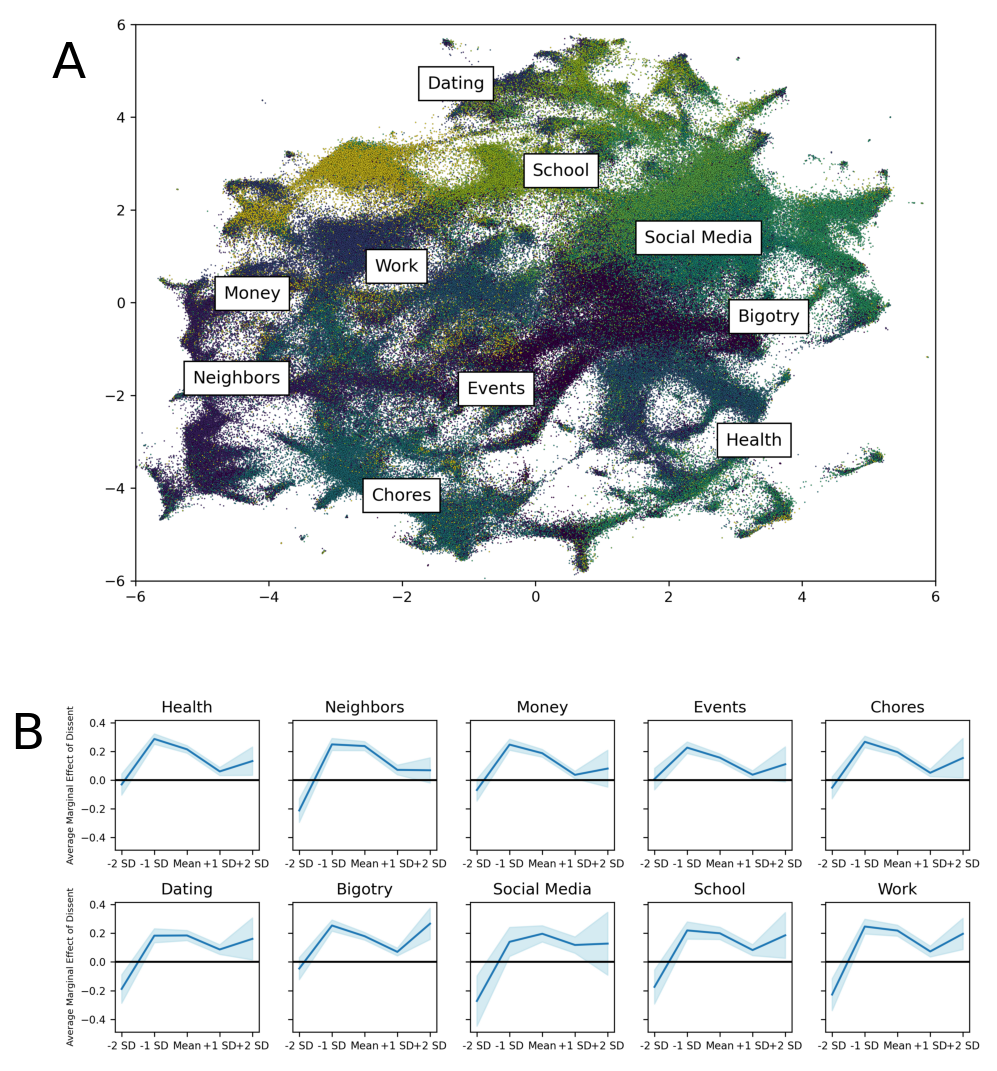

In [38]:
from matplotlib import image as mpimg

# List of your .tif files
tif_files = [
    'umap.tif',
    'heterogeneity_cubic.tif'
]

# Create subplots (2 rows, 1 column for vertically stacked plots)
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Loop over each subplot and load the corresponding image file
for i, ax in enumerate(axes):
    img = mpimg.imread(f'{graphpath}{tif_files[i]}')  # Read the .tif file as an image
    ax.imshow(img)  # Show the image in the subplot
    ax.axis('off')  # Turn off the axis for clarity (optional)
    
    # Add the panel label (A, B)
    ax.text(-0.05, 0.95, f'{chr(65 + i)}', transform=ax.transAxes, 
            fontsize=36, va='top', ha='left', color='black')

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(f'{graphpath}fig3_raw.tif', bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


# Fig 4. - RDIT

In [6]:
data = pd.read_stata(f'{datapath}aita_data_all.dta')

data = data[data['cum_score_absolute'] != 0]

data['consensus_disagree'] = 1 - data['consensus_agree']


data['num_comments'] = data.groupby('postid')['postid'].transform('count')
data = data[data['num_comments'] > 14]

data['comment_competition_ln'] = np.log(data['comment_competition'])
data['cs_majority'] = data['comment_competition_ln'] * data['current_consensus']
data['score_log'] = np.log(data['score'])

data = data[data['score'] > 0]

data = data[data['has_op_com'] == 1] #limit to posts with an op comment
data = data[abs(data['time_from_first_op_com_min']) <= 150]
data = data[~(data['time_from_first_op_com_min'] == 0)]

### Local graph

/var/folders/5w/62q1kz1164n7vbnq548l_6n80000gq/T/ipykernel_82166/3026217239.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = data.groupby('x_bin')['time_from_first_op_com_min'].mean()
/var/folders/5w/62q1kz1164n7vbnq548l_6n80000gq/T/ipykernel_82166/3026217239.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agree = data[data['consensus_disagree'] == 0].groupby('x_bin')['score_log'].mean()
/var/folders/5w/62q1kz1164n7vbnq548l_6n80000gq/T/ipykernel_82166/3026217239.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

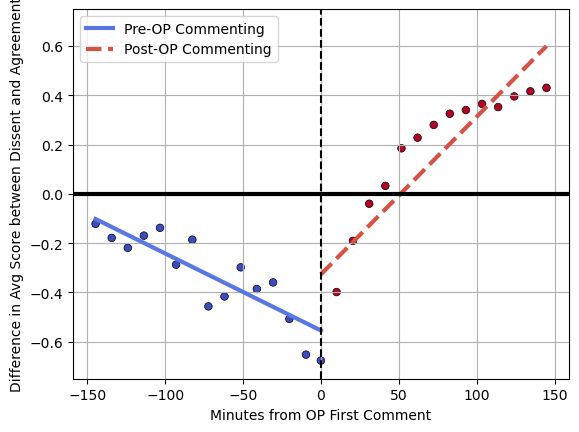

In [8]:
n_bins = 29

cmap = plt.get_cmap('coolwarm')
color_below_zero = cmap(0.1)  # Close to blue
color_above_zero = cmap(0.9)  # Close to red

# Binning the data
data['x_bin'] = pd.cut(data['time_from_first_op_com_min'], bins=n_bins, right=False)

# Calculate bin centers (mean of time_from_first_op_com_min per bin)
bin_centers = data.groupby('x_bin')['time_from_first_op_com_min'].mean()

# Calculate the difference in 'score_log' between agree and disagree for each bin
agree = data[data['consensus_disagree'] == 0].groupby('x_bin')['score_log'].mean()
disagree = data[data['consensus_disagree'] == 1].groupby('x_bin')['score_log'].mean()
y_bin_means = disagree - agree  # Difference between agree and disagree

# Create scatter plot
plt.scatter(
    bin_centers, y_bin_means, marker='o', linestyle='-', 
    c=(bin_centers >= 0).astype(int).values, cmap='coolwarm', 
    s=30, edgecolor='black', linewidth=0.5
)
plt.grid(axis='y')

# Split data at the midpoint for fitting
midpoint = int(np.round(n_bins / 2))

# Polynomial fit for the left side (negative values)
degree = 1
coefficients = np.polyfit(bin_centers[:midpoint].astype('float'), y_bin_means[:midpoint].astype('float'), degree)
polynomial = np.poly1d(coefficients)

x_poly_1 = np.linspace(min(bin_centers[:midpoint+1]), max(bin_centers[:midpoint+1]), int(n_bins / 2))
y_poly_1 = polynomial(x_poly_1)

# Polynomial fit for the right side (positive values)
coefficients_2 = np.polyfit(bin_centers[midpoint:].astype('float'), y_bin_means[midpoint:].astype('float'), degree)
polynomial_2 = np.poly1d(coefficients_2)

x_poly_2 = np.linspace(min(bin_centers[midpoint:]), max(bin_centers[midpoint:]), int(n_bins / 2))
y_poly_2 = polynomial_2(x_poly_2)

# Plot polynomial fits with legend labels and style changes
plt.plot(x_poly_1, y_poly_1, color=color_below_zero, linewidth=3, label='Pre-OP Commenting')
plt.plot(x_poly_2, y_poly_2, color=color_above_zero, linewidth=3, linestyle='--', label='Post-OP Commenting')

# Vertical cutoff line
plt.axvline(0, color='black', linestyle='--')

# Labels and grid
plt.xlabel('Minutes from OP First Comment')
plt.ylabel('Difference in Avg Score between Dissent and Agreement')
plt.ylim([-0.75, 0.75])
plt.axhline(0, color='black', linewidth=3)
plt.grid(True)

# Legend
plt.legend()

# Save and show plot
plt.savefig(f'{graphpath}fig4_raw.tif', bbox_inches="tight", dpi=300)
plt.show()


### Intermediate Outcome Graph

/var/folders/5w/62q1kz1164n7vbnq548l_6n80000gq/T/ipykernel_82166/2221128911.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cs = data.groupby('x_bin')['cs_majority'].mean()
/var/folders/5w/62q1kz1164n7vbnq548l_6n80000gq/T/ipykernel_82166/2221128911.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = data.groupby('x_bin')['time_from_first_op_com_min'].mean()


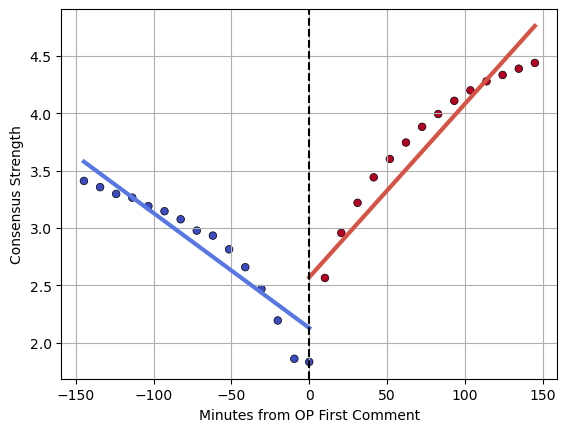

In [9]:

# Assuming 'data' is already loaded into the DataFrame
n_bins = 29

# Get two colors: one for below 0 (close to blue) and one for above 0 (close to red)
cmap = plt.get_cmap('coolwarm')
color_below_zero = cmap(0.1)  # Close to blue
color_above_zero = cmap(0.9)  # Close to red

# Binning the data
data['x_bin'] = pd.cut(data['time_from_first_op_com_min'], bins=n_bins, right=False)

# Calculate mean consensus strength for each bin
cs = data.groupby('x_bin')['cs_majority'].mean()
y_bin_means = cs  # The average consensus strength for each bin

# Calculate the center of each bin for plotting
bin_centers = data.groupby('x_bin')['time_from_first_op_com_min'].mean()

# Create scatter plot
plt.scatter(bin_centers, y_bin_means, marker='o', linestyle='-', c=(bin_centers >= 0).astype(int).values, cmap= 'coolwarm', s = 30, edgecolor = 'black', linewidth = 0.5) # Plot the binned averages


# Get midpoint to split data into two sides (left and right of 0)
midpoint = int(np.round(n_bins / 2))

# Polynomial fit for the left side (negative values)
degree = 1
coefficients = np.polyfit(bin_centers[:midpoint].astype('float'), y_bin_means[:midpoint].astype('float'), degree)
polynomial = np.poly1d(coefficients)

# Generate x-values for the polynomial curve on the left side (from min to max of the left bins)
x_poly_1 = np.linspace(min(bin_centers[:midpoint+1]), max(bin_centers[:midpoint+1]), int(n_bins / 2))
y_poly_1 = polynomial(x_poly_1)

# Polynomial fit for the right side (positive values)
coefficients_2 = np.polyfit(bin_centers[midpoint:].astype('float'), y_bin_means[midpoint:].astype('float'), degree)
polynomial_2 = np.poly1d(coefficients_2)

# Generate x-values for the polynomial curve on the right side (from min to max of the right bins)
x_poly_2 = np.linspace(min(bin_centers[midpoint:]), max(bin_centers[midpoint:]), int(n_bins / 2))
y_poly_2 = polynomial_2(x_poly_2)

# Plot the polynomial fits for both sides
plt.plot(x_poly_1, y_poly_1, color=color_below_zero, linewidth=3, label=f'Poly fit (degree {degree}) Below 0')
plt.plot(x_poly_2, y_poly_2, color=color_above_zero, linewidth=3, label=f'Poly fit (degree {degree}) Above 0')

# Add vertical line at x = 0 (cutoff)
plt.axvline(0, color='black', linestyle='--', label='Cutoff')

# Labels and grid
plt.xlabel('Minutes from OP First Comment')
plt.ylabel('Consensus Strength')
plt.grid(True)

# Save and show plot
plt.savefig(f'{graphpath}consensus_strength.png', bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
np.log(data['score']).hist()

In [ ]:
agree

### COMPRESS TIF IMAGES WITH LZW COMPRESSION

In [39]:
image = Image.open(f"{graphpath}fig1_raw.tif")
image.save(f"{graphpath}fig1.tif", compression="tiff_lzw")

image = Image.open(f"{graphpath}fig2_raw.tif")
image.save(f"{graphpath}fig2.tif", compression="tiff_lzw")

image = Image.open(f"{graphpath}fig3_raw.tif")
image.save(f"{graphpath}fig3.tif", compression="tiff_lzw")

image = Image.open(f"{graphpath}fig4_raw.tif")
image.save(f"{graphpath}fig4.tif", compression="tiff_lzw")



# SUPPLEMENTARY APPENDIX

## Consensus Measure Checks

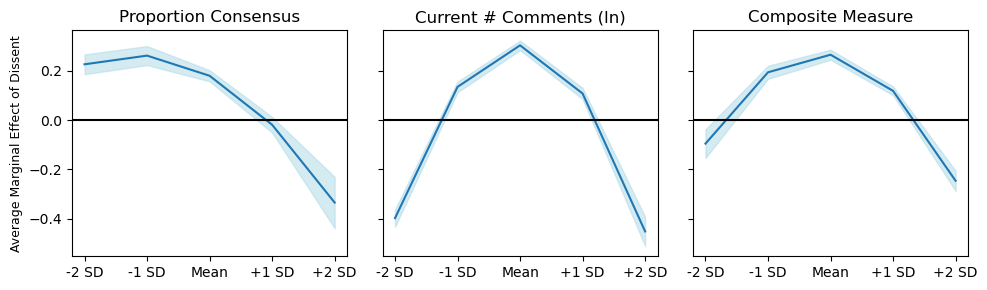

In [4]:
dfs = []
for df_num in [1,2,3]:
    df = pd.read_stata(f'{resultspath}margins_concheck_{df_num}.dta')
    at_options = df['_atopt'][0]
    at_options = re.findall(r"[-+]?\d*\.\d+|\d+", at_options)
    at_options = [float(num) for num in at_options]
    df['at_options'] = at_options
    df = df[['at_options', '_margin', '_pvalue', '_ci_lb', '_ci_ub']]
    df = df.rename(columns = {'_margin': 'margin', '_pvalue': 'pvalue', '_ci_lb': 'lower_bound', '_ci_ub': 'upper_bound'})
    index_labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
    df.index = index_labels
    dfs.append(df)

titles = ['Proportion Consensus', 'Current # Comments (ln)', 'Composite Measure']

# Calculate the number of rows and columns based on the number of subplots
n_plots = len(dfs)
n_cols = 3  # Set the number of columns you want
n_rows = math.ceil(n_plots / n_cols)  # Calculate the number of rows needed

# Create subplots with calculated rows and columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows), sharey=True)

# Flatten the axes array to iterate over easily
axes = axes.flatten()

# Plotting loop
for i, (ax, df) in enumerate(zip(axes, dfs)):
    ax.plot(df.index, df['margin'])
    ax.fill_between(df.index, df['lower_bound'], df['upper_bound'], 
                    color='lightblue', alpha=0.5, label='Confidence Interval')
    ax.axhline(0, color = 'black')
    ax.set_title(titles[i])
    if i % 3 == 0:  # For the first column only
        ax.set_ylabel('Average Marginal Effect of Dissent', fontsize=9)  # Adjust the label text and size


# Hide unused subplots if any
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{graphpath}figS1.png', bbox_inches="tight", dpi=300)
plt.show()


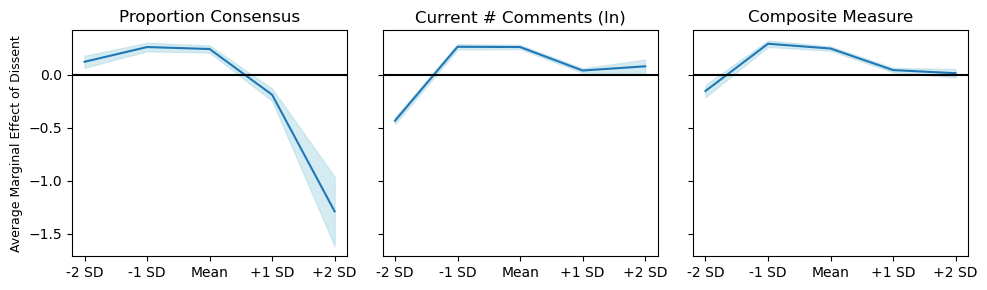

In [34]:
dfs = []
for df_num in [1,2,3]:
    df = pd.read_stata(f'{resultspath}margins_concheck_{df_num}_cubic.dta')
    at_options = df['_atopt'][0]
    at_options = re.findall(r"[-+]?\d*\.\d+|\d+", at_options)
    at_options = [float(num) for num in at_options]
    df['at_options'] = at_options
    df = df[['at_options', '_margin', '_pvalue', '_ci_lb', '_ci_ub']]
    df = df.rename(columns = {'_margin': 'margin', '_pvalue': 'pvalue', '_ci_lb': 'lower_bound', '_ci_ub': 'upper_bound'})
    index_labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
    df.index = index_labels
    dfs.append(df)

titles = ['Proportion Consensus', 'Current # Comments (ln)', 'Composite Measure']

# Calculate the number of rows and columns based on the number of subplots
n_plots = len(dfs)
n_cols = 3  # Set the number of columns you want
n_rows = math.ceil(n_plots / n_cols)  # Calculate the number of rows needed

# Create subplots with calculated rows and columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows), sharey=True)

# Flatten the axes array to iterate over easily
axes = axes.flatten()

# Plotting loop
for i, (ax, df) in enumerate(zip(axes, dfs)):
    ax.plot(df.index, df['margin'])
    ax.fill_between(df.index, df['lower_bound'], df['upper_bound'], 
                    color='lightblue', alpha=0.5, label='Confidence Interval')
    ax.axhline(0, color = 'black')
    ax.set_title(titles[i])
    if i % 3 == 0:  # For the first column only
        ax.set_ylabel('Average Marginal Effect of Dissent', fontsize=9)  # Adjust the label text and size


# Hide unused subplots if any
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{graphpath}figS1_cubic.png', bbox_inches="tight", dpi=300)
plt.show()


## Robustness Checks

In [45]:
#get effect sizes
for j in range(7):
    df = pd.read_stata(f'{resultspath}margins_robust_{j+1}.dta')

    for i in range(len(df)):
        result = (np.exp(df['_margin'][i]) - 1) * 100
        pvalue = df['_pvalue'][i]
        print(result)
        print(pvalue)
    print('-------------')
    

-14.396888017654419
8.4988507e-17
14.055216312408447
0.0
23.752987384796143
0.0
9.348058700561523
4.4437202e-20
-21.31691575050354
1.0563168e-17
-------------
-16.210490465164185
2.3892742e-19
15.725886821746826
0.0
26.680922508239746
0.0
9.908616542816162
1.009094e-20
-24.42258596420288
4.6980224e-21
-------------
-21.84962034225464
0.0
11.076152324676514
2.4967413e-31
24.438250064849854
0.0
9.882950782775879
1.7019526e-22
-23.519599437713623
1.1584099e-21
-------------
-5.17614483833313
0.059254415
21.12720012664795
0.0
26.797378063201904
0.0
8.773565292358398
1.6265827e-11
-23.531782627105713
7.9925284e-14
-------------
-12.86671757698059
9.536746e-15
15.627539157867432
0.0
24.594199657440186
0.0
9.016871452331543
3.9745075e-20
-22.54507541656494
6.1955137e-21
-------------
1.4976024627685547
0.41413915
16.311204433441162
0.0
19.23004388809204
0.0
9.332215785980225
3.6259704e-21
-10.31724214553833
6.0188813e-05
-------------
-11.371827125549316
3.8842646e-28
15.798628330230713
0.0
2

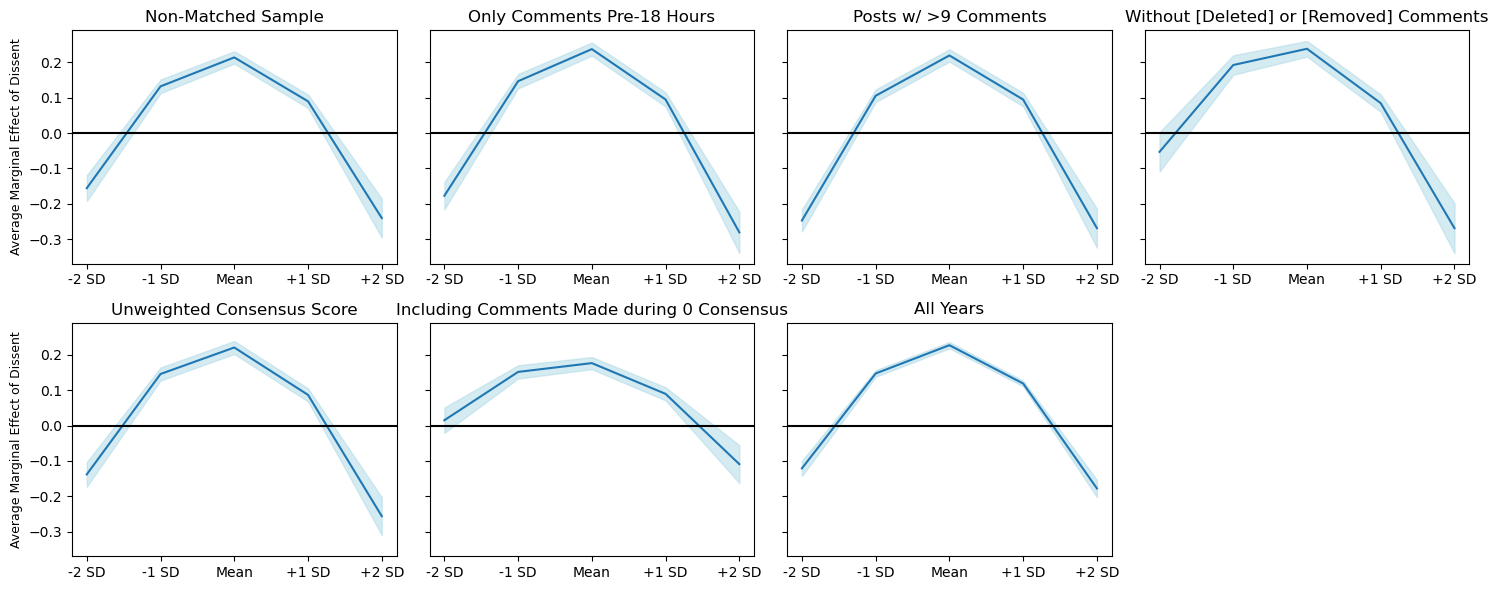

In [33]:
import math

dfs = []
for df_num in [1,2,3,4,5,6,7]:
    df = pd.read_stata(f'{resultspath}margins_robust_{df_num}.dta')
    at_options = df['_atopt'][0]
    at_options = re.findall(r"[-+]?\d*\.\d+|\d+", at_options)
    at_options = [float(num) for num in at_options]
    df['at_options'] = at_options
    df = df[['at_options', '_margin', '_pvalue', '_ci_lb', '_ci_ub']]
    df = df.rename(columns = {'_margin': 'margin', '_pvalue': 'pvalue', '_ci_lb': 'lower_bound', '_ci_ub': 'upper_bound'})
    index_labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
    df.index = index_labels
    dfs.append(df)

titles = ['Non-Matched Sample', 'Only Comments Pre-18 Hours', 'Posts w/ >9 Comments', 
          'Without [Deleted] or [Removed] Comments', 'Unweighted Consensus Score', 'Including Comments Made during 0 Consensus', 'All Years']

# Calculate the number of rows and columns based on the number of subplots
n_plots = len(dfs)
n_cols = 4  # Set the number of columns you want
n_rows = math.ceil(n_plots / n_cols)  # Calculate the number of rows needed

# Create subplots with calculated rows and columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), sharey=True)

# Flatten the axes array to iterate over easily
axes = axes.flatten()

# Plotting loop
for i, (ax, df) in enumerate(zip(axes, dfs)):
    ax.plot(df.index, df['margin'])
    ax.fill_between(df.index, df['lower_bound'], df['upper_bound'], 
                    color='lightblue', alpha=0.5, label='Confidence Interval')
    ax.axhline(0, color = 'black')
    ax.set_title(titles[i])
    if i % 4 == 0:  # For the first column only
        ax.set_ylabel('Average Marginal Effect of Dissent', fontsize=9)  # Adjust the label text and size

# Hide unused subplots if any
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{graphpath}figS2.png', bbox_inches="tight", dpi = 300)
plt.show()

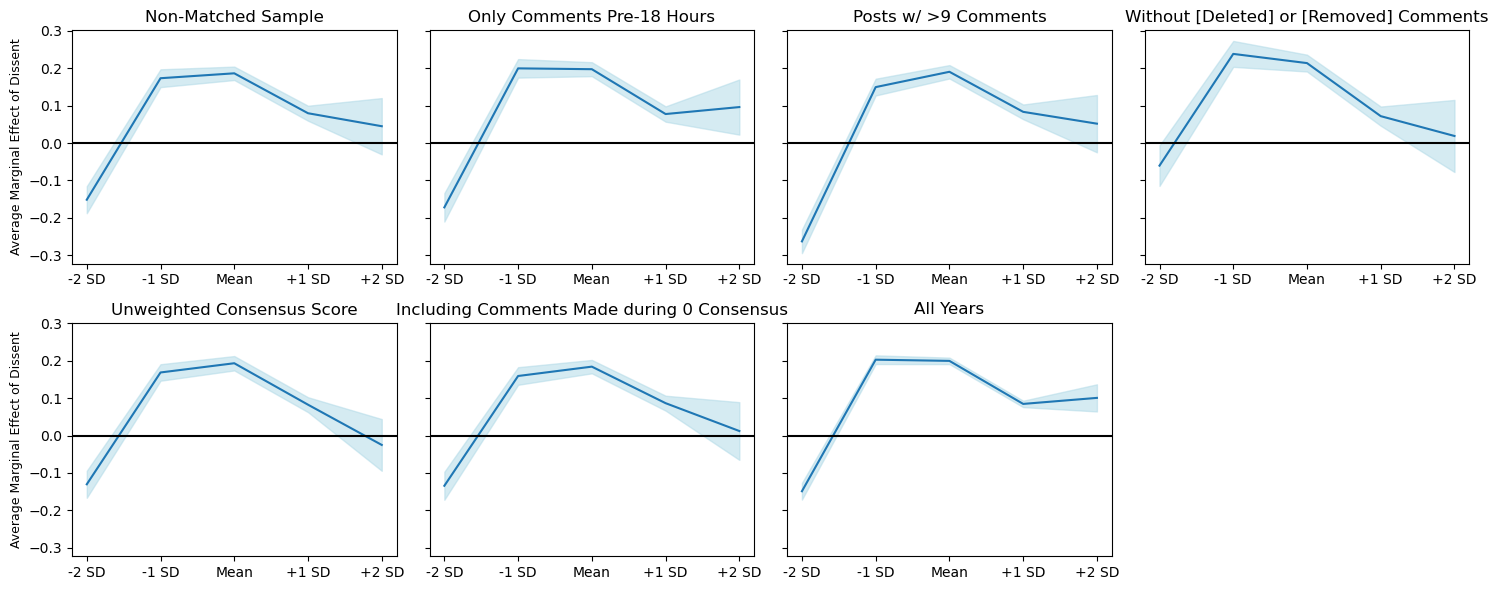

In [32]:
import math

dfs = []
for df_num in [1,2,3,4,5,6,7]:
    df = pd.read_stata(f'{resultspath}margins_robust_{df_num}_cubic.dta')
    at_options = df['_atopt'][0]
    at_options = re.findall(r"[-+]?\d*\.\d+|\d+", at_options)
    at_options = [float(num) for num in at_options]
    df['at_options'] = at_options
    df = df[['at_options', '_margin', '_pvalue', '_ci_lb', '_ci_ub']]
    df = df.rename(columns = {'_margin': 'margin', '_pvalue': 'pvalue', '_ci_lb': 'lower_bound', '_ci_ub': 'upper_bound'})
    index_labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
    df.index = index_labels
    dfs.append(df)

titles = ['Non-Matched Sample', 'Only Comments Pre-18 Hours', 'Posts w/ >9 Comments', 
          'Without [Deleted] or [Removed] Comments', 'Unweighted Consensus Score', 'Including Comments Made during 0 Consensus', 'All Years']

# Calculate the number of rows and columns based on the number of subplots
n_plots = len(dfs)
n_cols = 4  # Set the number of columns you want
n_rows = math.ceil(n_plots / n_cols)  # Calculate the number of rows needed

# Create subplots with calculated rows and columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), sharey=True)

# Flatten the axes array to iterate over easily
axes = axes.flatten()

# Plotting loop
for i, (ax, df) in enumerate(zip(axes, dfs)):
    ax.plot(df.index, df['margin'])
    ax.fill_between(df.index, df['lower_bound'], df['upper_bound'], 
                    color='lightblue', alpha=0.5, label='Confidence Interval')
    ax.axhline(0, color = 'black')
    ax.set_title(titles[i])
    if i % 4 == 0:  # For the first column only
        ax.set_ylabel('Average Marginal Effect of Dissent', fontsize=9)  # Adjust the label text and size

# Hide unused subplots if any
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{graphpath}figS2_cubic.png', bbox_inches="tight", dpi = 300)
plt.show()

## Representative Words from Top2Vec

In [ ]:
model = Top2Vec.load(f'{datapath}aitamodel')
topic_words, word_scores, topic_nums = model.get_topics(reduced=True)
topicwords = pd.DataFrame(topic_words).T
topicwords.columns = ['Health', 'Neighbors', 'Money', 'Events', 'Chores', 'Dating', 'Bigotry', 'Social Media', 'School', 'Work']
topicwords = topicwords[:20]

In [ ]:
latex_code = topicwords.to_latex(index=False, escape=False)

for col in topicwords.columns:
    latex_code = latex_code.replace(f"{col}", f"\\textbf{{{col}}}")

# Add the \resizebox command to fit the page width
latex_code_with_resize = r"\resizebox{\textwidth}{!}{" + latex_code + "}"

# Save the LaTeX code to a .tex file
with open(f'{graphpath}topicwords.tex', 'w') as f:
    f.write(latex_code_with_resize)

In [ ]:
# # For checking
# posts = pd.read_parquet(f'{datapath}AmItheAsshole_submissions.parquet').astype({'id':'str','selftext':'str', 'title': 'str', 'author': 'str', 'created_utc': 'float', 'score': 'int', 'distinguished': 'str','link_flair_text': 'str', 'link_flair_css_class': 'str'})
# posts = posts[~(posts['selftext'] == '[deleted]')]
# posts = posts[~(posts['selftext'] == '[removed]')]
# posts = posts[~(posts['selftext'] == '['']')]
# post_topics = pd.read_parquet(f'{datapath}posttopics.parquet')
# posts['topic'] = post_topics['topic'].values
# posts['topic_name'] = post_topics['topic_name'] #map to names
# pd.set_option('display.max_colwidth', None)
# posts[['title','selftext', 'topic', 'topic_name']].head(50)